# 8. Multiple input Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dropout,Dense,concatenate
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns

plt.style.use("default")

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jasonola/opt/an

In [2]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r X_train_img
%store -r X_test_img
%store -r y_train_img
%store -r y_test_img
%store -r label_encoder
%store -r classes
%store -r feature_names


In [3]:
X_train_img = X_train_img.reshape(750,218,336,1)
X_test_img = X_test_img.reshape(250,218,336,1)

Last but not least, we can use keras functional API to take into account multiple inputs, like our neural network on our CSV data and our convolutional neural network on our image data.

In [4]:
input_shape_csv = X_train.shape[-1]
input_shape_img = X_train_img.shape[-3:]
no_logits = y_train_img.max()+1
early_stopping = keras.callbacks.EarlyStopping(patience=5,monitor="acc")

so we have 2 inputs in our case, let's define them : 

In [5]:
input_csv = Input((input_shape_csv,))
input_img = Input(input_shape_img)

Now let's create our 2 models with these inputs

In [6]:
x = Dense(32, activation="relu")(input_csv)
x = Model(inputs=input_csv,outputs=x)

y = Conv2D(filters=16,kernel_size=(5,5),strides=(2,2),padding="same",activation="relu")(input_img)
y = MaxPool2D(strides=(2,2),padding="same")(y)
y = Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu")(y)
y = MaxPool2D(strides=(2,2),padding="same")(y)
y = Flatten()(y)
y = Dropout(0.5)(y)
y = Dense(units=256,activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(y)
y = Model(inputs=input_img,outputs=y)

Now we have our 2 models x and y that we directly took from our previous notebooks.  
We can now combine our 2 models by concatenating the outputs 

In [7]:
combined = concatenate([x.output, y.output])

In [8]:
z = Dense(units=no_logits,activation="softmax")(combined)

In [9]:
model = Model(inputs=[x.input, y.input], outputs=z)

In [10]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["acc"])

In [11]:
model.fit([X_train,X_train_img],y_train,epochs=50,callbacks=[early_stopping]);

Epoch 1/50
750/750 [==============================] - 9s 12ms/step - loss: 4.2695 - acc: 0.2427
Epoch 2/50
750/750 [==============================] - 6s 8ms/step - loss: 2.1127 - acc: 0.4813
Epoch 3/50
750/750 [==============================] - 6s 8ms/step - loss: 1.6796 - acc: 0.6253
Epoch 4/50
750/750 [==============================] - 6s 8ms/step - loss: 1.5230 - acc: 0.6640
Epoch 5/50
750/750 [==============================] - 6s 8ms/step - loss: 1.3683 - acc: 0.7520
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 1.2780 - acc: 0.7787
Epoch 7/50
750/750 [==============================] - 6s 8ms/step - loss: 1.1675 - acc: 0.8373
Epoch 8/50
750/750 [==============================] - 6s 8ms/step - loss: 1.0967 - acc: 0.8693
Epoch 9/50
750/750 [==============================] - 6s 8ms/step - loss: 0.9663 - acc: 0.9053
Epoch 10/50
750/750 [==============================] - 6s 8ms/step - loss: 0.8616 - acc: 0.9213
Epoch 11/50
750/750 [===========================

We see that the early stopping does it's work.  
Let's plot the accuracy and loss curves : 

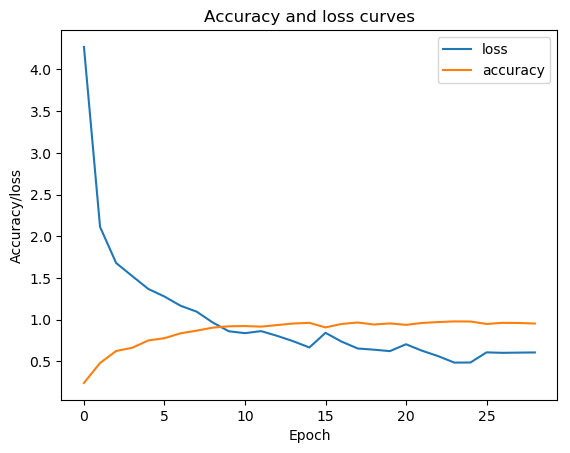

In [12]:
plt.plot(model.history.history["loss"],label="loss")
plt.plot(model.history.history["acc"],label="accuracy")
plt.title("Accuracy and loss curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/loss")
plt.legend();

Now let's see how the model does with confusion matrix and the classification report

In [13]:
y_pred = (model.predict([X_test,X_test_img])>0.5)+0

In [14]:
y_pred = np.argmax(y_pred, axis=1)

In [15]:
cm = confusion_matrix(y_test, y_pred)

In [16]:
cmdf = pd.DataFrame(cm,columns=classes,index=classes)

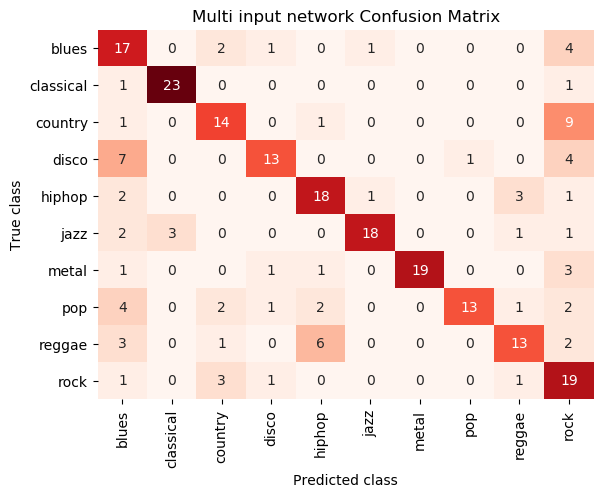

In [17]:
sns.heatmap(cmdf, annot=True, cmap="Reds",cbar=False)
plt.title("Multi input network Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class");

In [18]:
report = classification_report(y_test, y_pred,target_names=classes,output_dict=True)

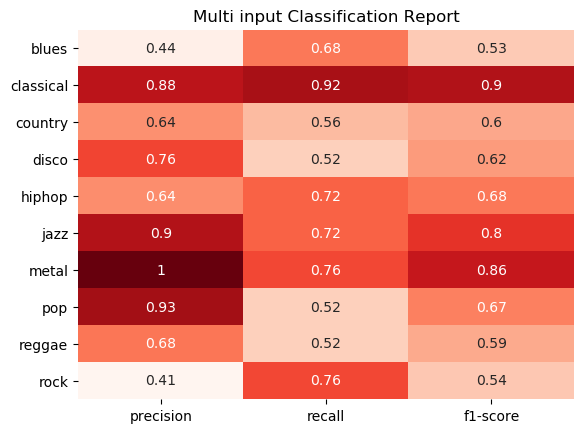

In [19]:
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, cmap="Reds",cbar=False)
plt.title("Multi input Classification Report");

We see that the mixed model doesn't do much better than our previous models, it also struggle to classify rock well and here blues and country doesn't do well either. 